# Artificial Neural Networks and Deep Learning

---

## Homework 2: Minimal Working Example

To make your first submission, follow these steps:
1. Create a folder named `[2024-2025] AN2DL/Homework 2` in your Google Drive.
2. Upload the `mars_for_students.npz` file to this folder.
3. Upload the Jupyter notebook `Homework 2 - Minimal Working Example.ipynb`.
4. Load and process the data.
5. Implement and train your model.
6. Submit the generated `.csv` file to Kaggle.


## 🌐 Connect Colab to Google Drive

In [1]:
from google.colab import drive

drive.mount("/gdrive")
%cd /gdrive/MyDrive/Polimi/ANNDL/challenge2

Mounted at /gdrive
/gdrive/MyDrive/Polimi/ANNDL/challenge2


## ⚙️ Import Libraries

In [2]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

from datetime import datetime
import pandas as pd

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.17.1


## ⏳ Load the Data

In [3]:
data = np.load("mars_for_students.npz")

training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]

X_test = data["test_set"]

# Separiamo il train set in training e validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42  # 20% per il validation set
)

# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis] / 255.0
###
X_val = X_val[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0

y_train = y_train.astype(np.int32)
y_val = y_val.astype(np.int32)

print(f"Training X shape: {X_train.shape}")
print(f"Validation X shape: {X_val.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2092, 64, 128, 1)
Validation X shape: (523, 64, 128, 1)
Training y shape: (2092, 64, 128)
Test X shape: (10022, 64, 128, 1)


In [4]:
category_map = {
  0: 0, #Background
  1: 1, #Soil
  2: 2, #Bedrock
  3: 3, #Sand
  4: 4, #Big Rock
}

In [5]:
def visualize_image_label_pairs(X, y, num_images, class_names, reverse=0):
    """
    Visualize pairs of original images and their corresponding label overlays,
    and add a color legend for the labels.

    Args:
        X: Array of images (shape: [num_samples, height, width, channels]).
        y: Array of labels (shape: [num_samples, height, width]).
        num_images: Number of image-label pairs to visualize.
        class_names: List of class names (optional). If provided, a legend will be added.
    """

    if reverse == 1:
        X = X[::-1]
        y = y[::-1]

    # Set up the grid layout: 2 columns, num_images rows
    fig, axes = plt.subplots(num_images, 2, figsize=(10, 5 * num_images))

    # Define a custom colormap for the legend
    if class_names is not None:
        cmap = mcolors.ListedColormap(plt.cm.jet(np.linspace(0, 1, len(class_names))))
        norm = mcolors.BoundaryNorm(np.arange(len(class_names)+1), len(class_names))
    else:
        cmap = 'jet'
        norm = None

    for i in range(num_images):
        # Extract the image and its corresponding label
        image = X[i]
        label = y[i]

        # Show the original image in the first column
        ax = axes[i, 0] if num_images > 1 else axes[0]
        ax.imshow(image.squeeze(), cmap='gray')  # Use squeeze for grayscale images
        ax.axis('off')
        ax.set_title(f"Image {i+1}")

        # Show the image with the label overlay in the second column
        ax = axes[i, 1] if num_images > 1 else axes[1]
        ax.imshow(image.squeeze(), cmap='gray')  # Background: original image
        ax.imshow(label, alpha=0.5, cmap=cmap, norm=norm)  # Label overlay
        ax.axis('off')
        ax.set_title(f"Label Overlay {i+1}")

    # Add the legend if class names are provided
    if class_names is not None:
        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(i), markersize=10) for i in range(len(class_names))]
        plt.legend(handles, class_names, title="Class Labels", bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

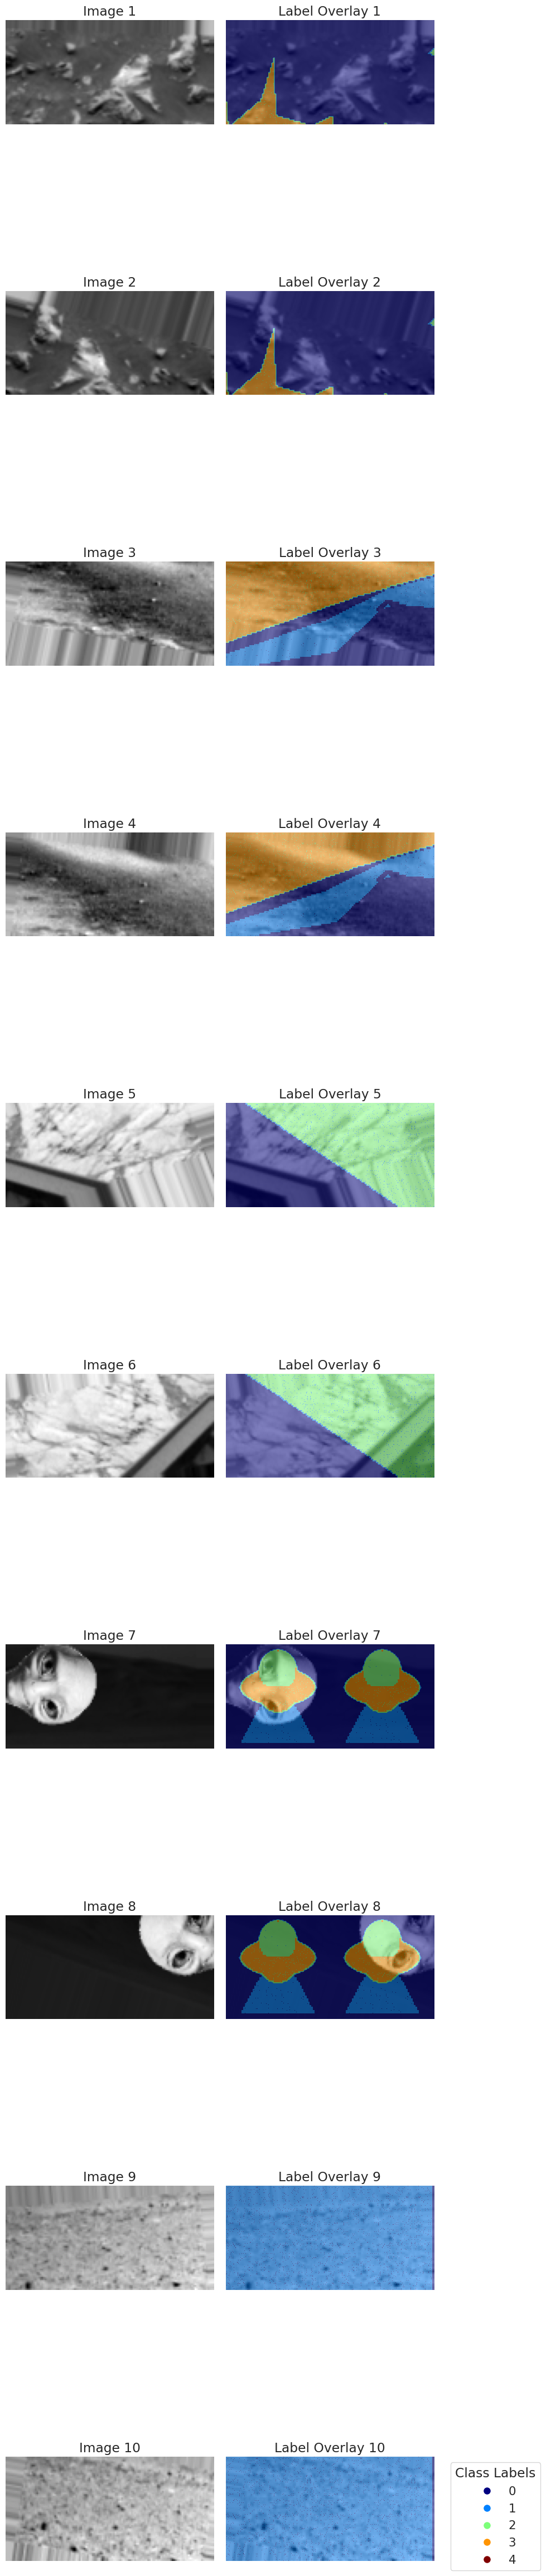

In [9]:
visualize_image_label_pairs(X_train, y_train, num_images=10, class_names=category_map, reverse=1)

##Apply augmentation

In [5]:
# Function to apply data augmentation
def augment_data(X, y, augmenter, num_augmentations=1):
    """
    Perform data augmentation on the dataset and return augmented images and labels.

    Parameters:
    - X: array of images of shape (num_samples, height, width, channels)
    - y: array of labels (segmentation masks) of shape (num_samples, height, width)
    - augmenter: an image augmentation generator (e.g., from Keras)
    - num_augmentations: number of augmentations to generate for each image

    Returns:
    - augmented_X: augmented images
    - augmented_y: corresponding labels (must remain integer labels)
    """
    augmented_X, augmented_y = [], []

    for i in range(len(X)):
        img = X[i].reshape((1,) + X[i].shape)  # Expand to 4 dimensions
        label = y[i]

        # Ensure that labels are integers (just in case)
        label = label.astype(int)

        for _ in range(num_augmentations):
            for augmented_img in augmenter.flow(img, batch_size=1):
                augmented_X.append(augmented_img[0])  # Add augmented image
                augmented_y.append(label)  # Add corresponding label (unchanged)
                break  # Exit to avoid duplicates

    return np.array(augmented_X), np.array(augmented_y)

In [6]:
# Define data augmentation parameters
augmenter = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Apply data augmentation to the training set
augmented_X, augmented_y = augment_data(X_train, y_train, augmenter, num_augmentations=2)

# Concatenate original data with augmented data
X_train_augmented = np.concatenate((X_train, augmented_X), axis=0)
y_train_augmented = np.concatenate((y_train, augmented_y), axis=0)

# Print dataset shapes
print(f"Original training set size: {X_train.shape}")
print(f"Augmented training set size: {X_train_augmented.shape}")
print(f"Original labels size: {y_train.shape}")
print(f"Augmented labels size: {y_train_augmented.shape}")

X_train = X_train_augmented
y_train = y_train_augmented

Original training set size: (2092, 64, 128, 1)
Augmented training set size: (6276, 64, 128, 1)
Original labels size: (2092, 64, 128)
Augmented labels size: (6276, 64, 128)


Visualizing examples from the training set:


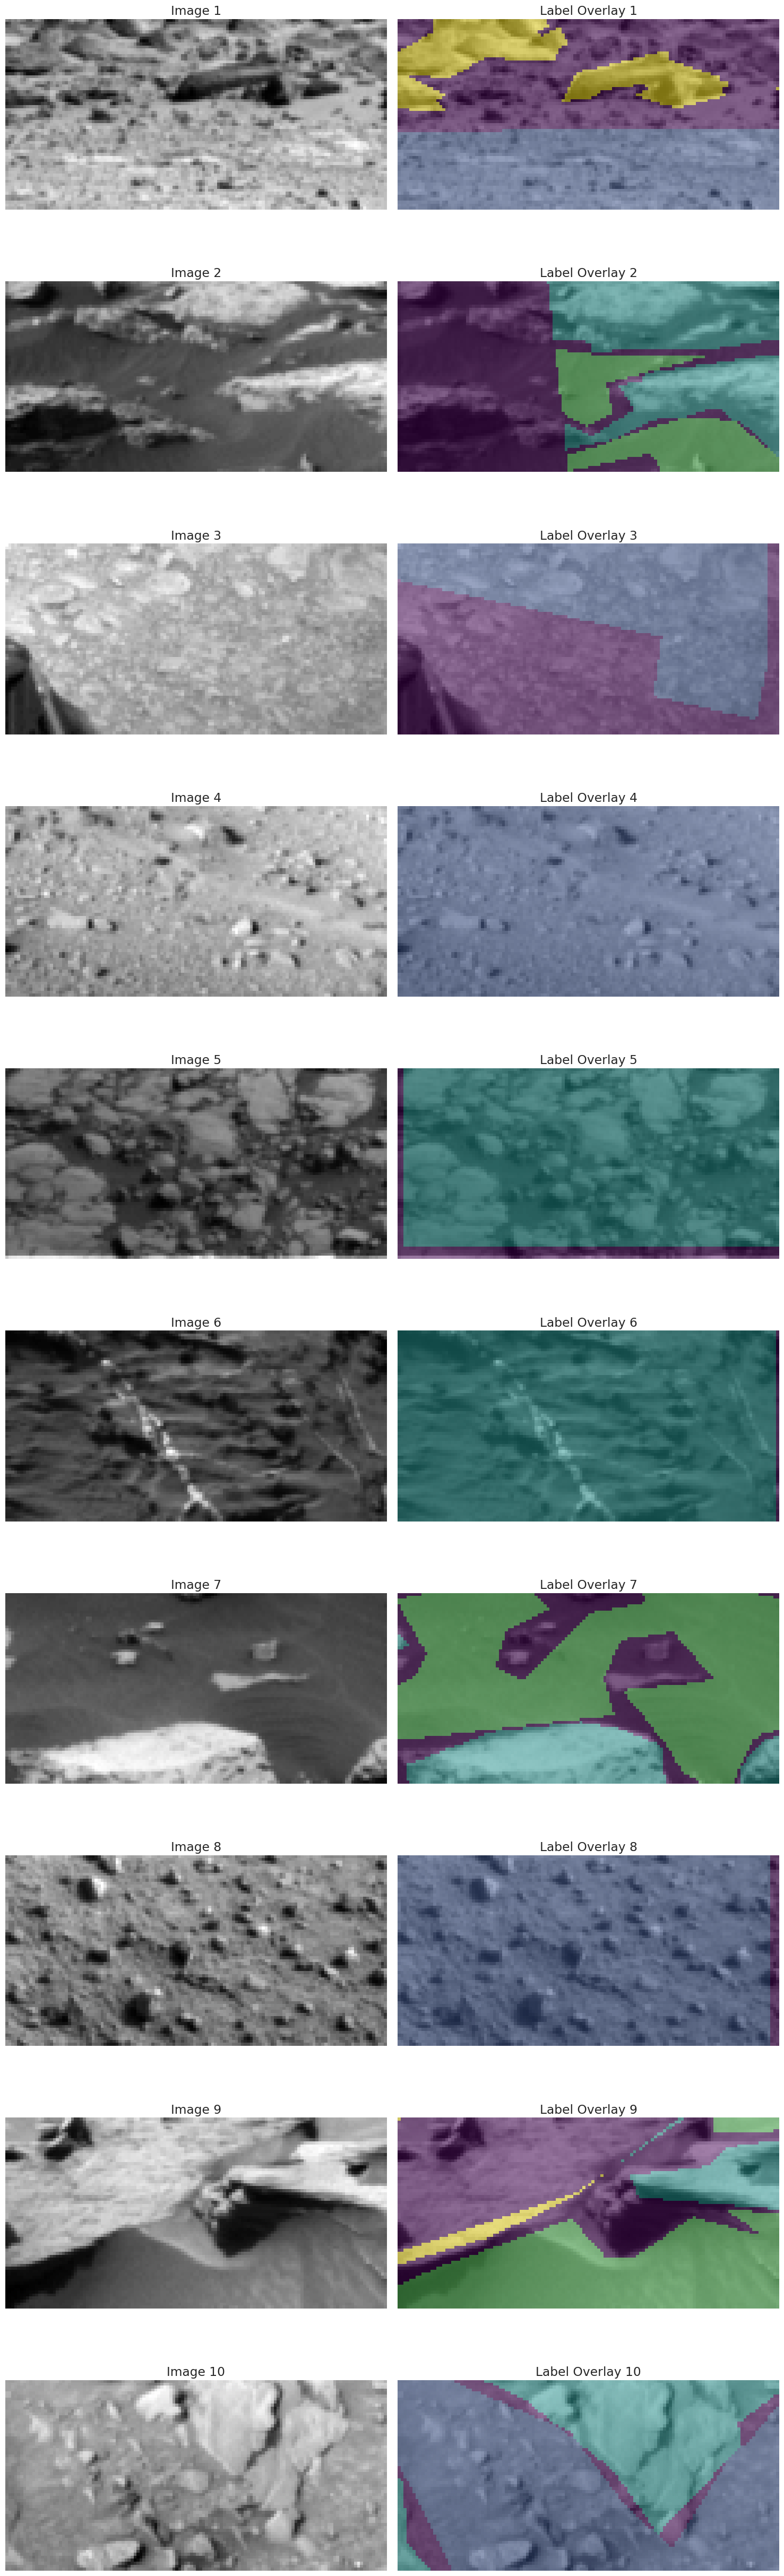

In [7]:
def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

def plot_sample_batch(x, y, num_samples=3, class_names=None):
    """
    Display some image and label pairs with label overlays.
    Parameters:
    - x: Array of images.
    - y: Array of labels.
    - num_samples: Number of samples to display.
    - class_names: List of class names for the legend.
    """
    plt.figure(figsize=(15, 5 * num_samples))

    num_classes = len(np.unique(y))
    colormap = create_segmentation_colormap(num_classes)

    for j in range(min(num_samples, len(x))):
        # Plot original image
        plt.subplot(num_samples, 2, j * 2 + 1)
        plt.imshow(x[j].squeeze(), cmap='gray')  # Display grayscale image
        plt.title(f'Image {j+1}')
        plt.axis('off')

        # Plot image with label overlay
        plt.subplot(num_samples, 2, j * 2 + 2)
        plt.imshow(x[j].squeeze(), cmap='gray')  # Display grayscale image as background
        colored_label = apply_colormap(y[j], colormap)
        plt.imshow(colored_label, alpha=0.5)  # Overlay label with transparency
        plt.title(f'Label Overlay {j+1}')
        plt.axis('off')

    # Add legend if class names are provided
    if class_names is not None:
        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colormap[i], markersize=10)
                   for i in range(len(class_names))]
        plt.legend(handles, class_names, title="Class Labels", bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()
    plt.close()

# Example usage
print("Visualizing examples from the training set:")
plot_sample_batch(X_train, y_train, num_samples=10)

##Build model

In [8]:
num_classes = len(np.unique(y_train))
input_shape = (64, 128, 1)

In [9]:
# Definizione del blocco dell'encoder
def encoder_block(input_tensor, num_filters):
    # Primo layer convoluzionale
    x = tfkl.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.LeakyReLU(negative_slope=0.1)(x)
    x = tfkl.Dropout(0.3)(x)

    # Secondo layer convoluzionale
    x = tfkl.Conv2D(num_filters, (3, 3), padding='same')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.LeakyReLU(negative_slope=0.1)(x)
    x = tfkl.Dropout(0.3)(x)

    # MaxPooling per downsampling
    p = tfkl.MaxPooling2D((2, 2))(x)
    return x, p

# Definizione del blocco del decoder
def decoder_block(input_tensor, concat_tensor, num_filters):
    # Upsampling (upscaling) della feature map
    x = tfkl.Conv2DTranspose(num_filters, (3, 3), strides=(2, 2), padding='same')(input_tensor)

    # Concatenazione con l'output dell'encoder corrispondente
    x = tfkl.concatenate([x, concat_tensor])

    # Convoluzione dopo la concatenazione
    x = tfkl.Conv2D(num_filters, (3, 3), padding='same')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.LeakyReLU(negative_slope=0.1)(x)
    x = tfkl.Dropout(0.3)(x)

    x = tfkl.Conv2D(num_filters, (3, 3), padding='same')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.LeakyReLU(negative_slope=0.1)(x)
    x = tfkl.Dropout(0.3)(x)

    return x

def build_dual_unet(input_shape, num_filters=64, num_classes=5):
    inputs = tfkl.Input(shape=input_shape)

    # Encoder per la parte dettagliata (conserviamo risoluzione più alta)
    encoder1, pool1 = encoder_block(inputs, num_filters)
    encoder2, pool2 = encoder_block(pool1, num_filters * 2)
    encoder3, pool3 = encoder_block(pool2, num_filters * 4)

    # Decoder per la parte dettagliata
    decoder1 = decoder_block(encoder3, encoder2, num_filters * 2)
    decoder2 = decoder_block(decoder1, encoder1, num_filters)

    # Encoder per la parte globale (riduzione risoluzione più rapida)
    encoder_g1, pool_g1 = encoder_block(inputs, num_filters)
    encoder_g2, pool_g2 = encoder_block(pool_g1, num_filters * 2)

    # Decoder per la parte globale
    decoder_g1 = decoder_block(encoder_g2, encoder_g1, num_filters)

    # Fusione dei due rami (dettagliato e globale)
    merged = tfkl.concatenate([decoder2, decoder_g1])

    # Output finale: 5 canali per le 5 classi, usando softmax per probabilità
    output = tfkl.Conv2D(num_classes, (1, 1), activation='softmax')(merged)

    model = tf.keras.Model(inputs=inputs, outputs=output)

    return model

model = build_dual_unet(input_shape)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 64, 128, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 64, 128, 64)    │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 64, 128, 64)    │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 64, 128, 64)    │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 64, 128, 64)    │              0 │ leaky_re_lu[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 64, 128, 64)    │         36,928 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 64, 128, 64)    │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU) │ (None, 64, 128, 64)    │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64, 128, 64)    │              0 │ leaky_re_lu_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 32, 64, 64)     │              0 │ dropout_1[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 64, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 32, 64, 128)    │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU) │ (None, 32, 64, 128)    │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 32, 64, 128)    │              0 │ leaky_re_lu_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 64, 128)    │        147,584 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 32, 64, 128)    │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_3 (LeakyReLU) │ (None, 32, 64, 128)    │              0 │ batch_normalization_3… │
├──────────────────────

 Total params: 2,517,765 (9.60 MB)

 Trainable params: 2,514,181 (9.59 MB)

 Non-trainable params: 3,584 (14.00 KB)

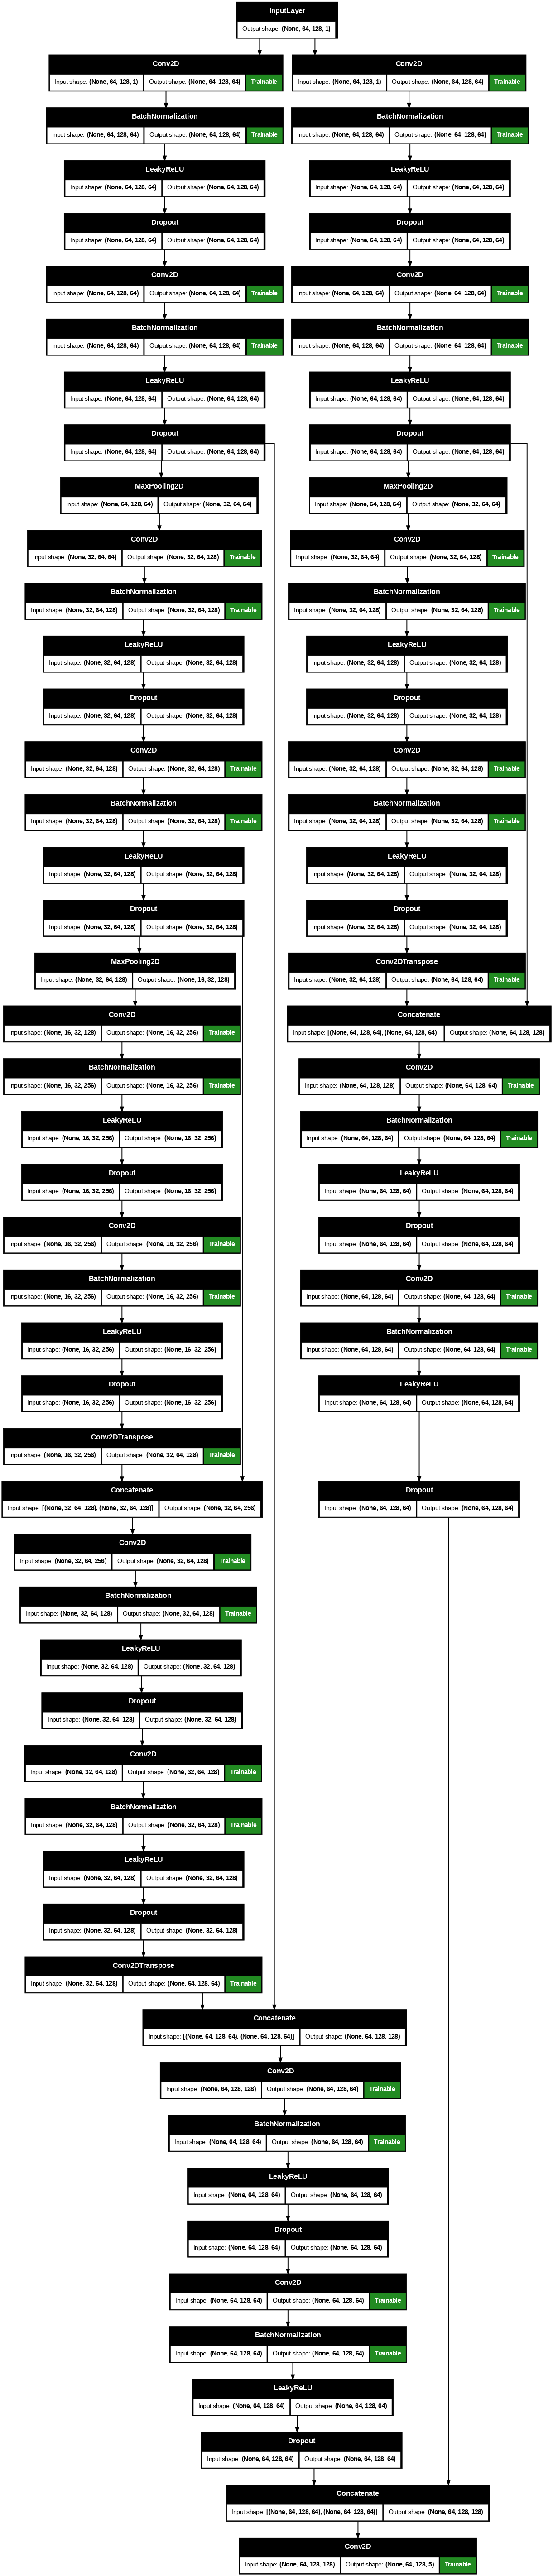

In [10]:
model.summary()
# Visualize the model and save the image
tfk.utils.plot_model(model, show_trainable=True, show_shapes=True, dpi=70)

## 🛠️ Train and Save the Model

In [11]:
def masked_loss(y_true, y_pred):
    # Create a mask to exclude pixels with label 0
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)

    # Compute standard loss (sparse categorical crossentropy)
    loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)

    # Apply the mask (exclude pixels with label 0)
    loss = loss * mask

    # Return the mean loss over all pixels
    return tf.reduce_sum(loss) / tf.reduce_sum(mask)

In [12]:
# Define the MeanIoU ignoring the background class
mean_iou = tfk.metrics.MeanIoU(num_classes=num_classes, ignore_class=0, sparse_y_pred=False)

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=[mean_iou])

In [13]:
# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,          # Stop after 10 epochs without improvement
    restore_best_weights=True  # Restore model weights from the best epoch
)

# Learning rate scheduler (ReduceLR on Plateau)
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',   # Monitor validation loss
    factor=0.5,           # Reduce learning rate by 50%
    patience=3,           # Wait for 3 epochs before reducing LR
    min_lr=1e-6           # Minimum learning rate
)

In [14]:
# Train the model with early stopping and learning rate scheduler
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=100
)

Epoch 1/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 58s 128ms/step - loss: 1.4980 - mean_io_u: 0.1351 - val_loss: 2.4510 - val_mean_io_u: 0.0550
Epoch 2/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 1.2413 - mean_io_u: 0.2105 - val_loss: 1.3441 - val_mean_io_u: 0.1921
Epoch 3/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 1.1152 - mean_io_u: 0.2678 - val_loss: 1.3359 - val_mean_io_u: 0.2417
Epoch 4/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - loss: 1.0670 - mean_io_u: 0.2873 - val_loss: 1.5797 - val_mean_io_u: 0.1812
Epoch 5/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 1.0274 - mean_io_u: 0.3071 - val_loss: 0.9951 - val_mean_io_u: 0.3345
Epoch 6/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - loss: 1.0127 - mean_io_u: 0.3132 - val_loss: 0.9937 - val_mean_io_u: 0.3528
Epoch 7/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 0.9898 - mean_io_u: 0.3259 - val_loss: 0.9420 - val_mean_io_u: 0.3642
Epoch 8/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 0.9782 - mea

In [15]:
# Save the trained model to a file with the accuracy included in the filename
model_filename = 'model4.keras'
model.save(model_filename)

##Results

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step


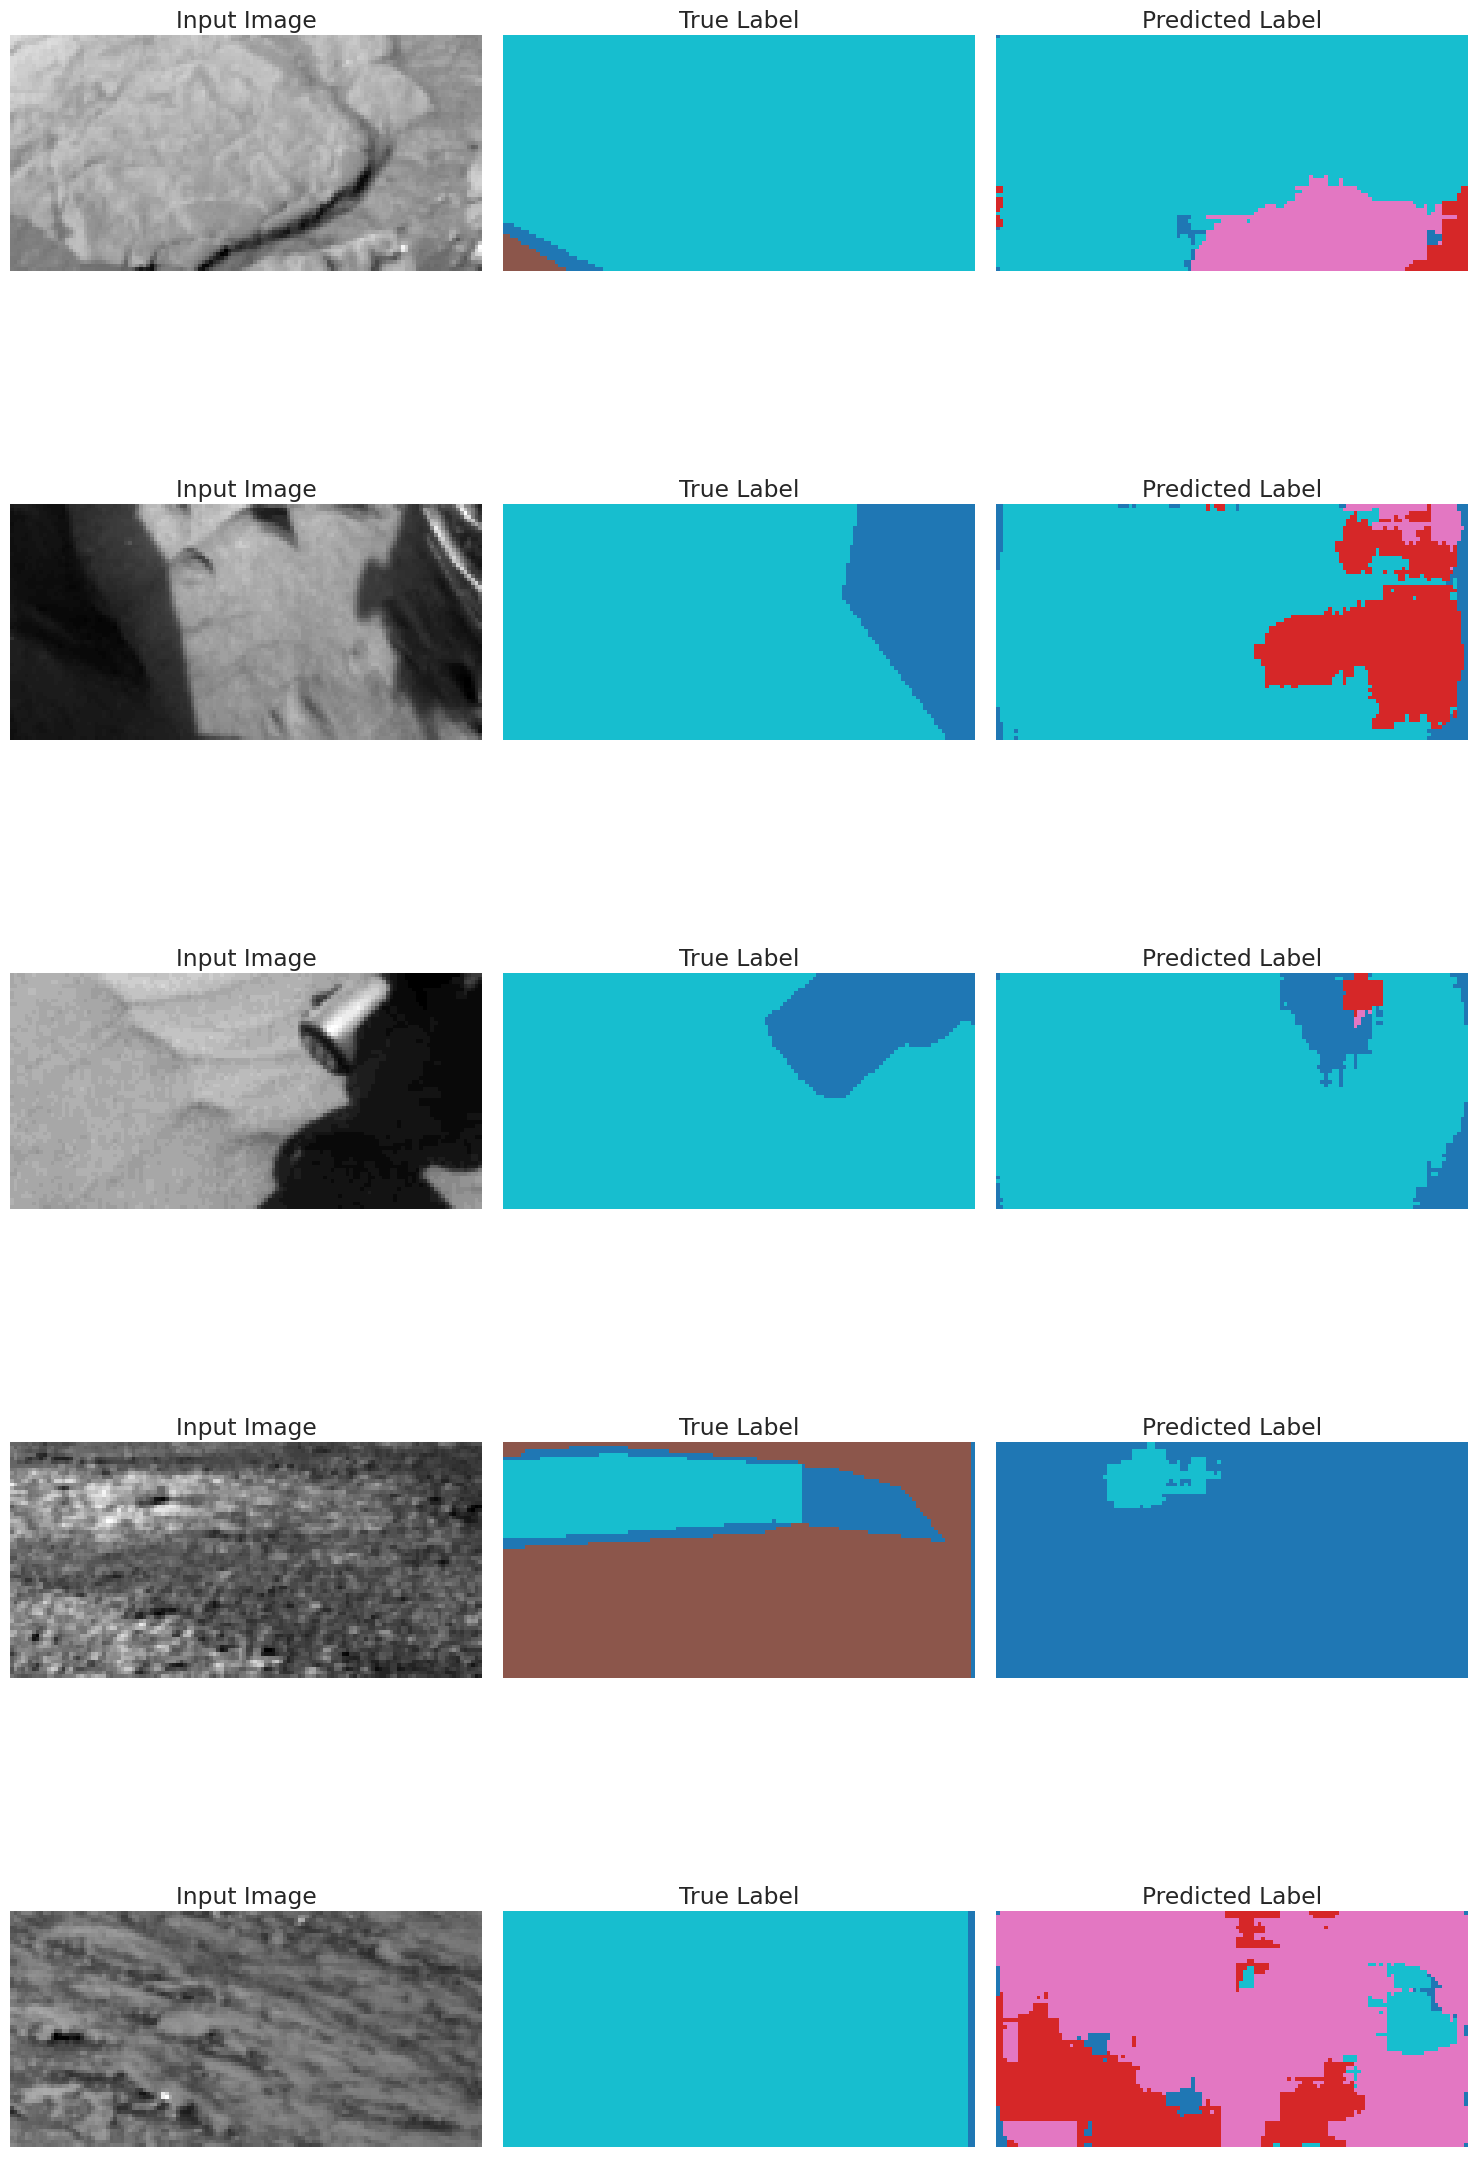

In [16]:
# Make predictions on the validation set
predictions = model.predict(X_val)
predicted_classes = np.argmax(predictions, axis=-1)

# Function to visualize predictions
def visualize_predictions(X, y_true, y_pred, num_examples=5):
    """
    Visualize predictions vs true labels for the validation set.
    Args:
        X: Input images (validation set).
        y_true: True labels.
        y_pred: Predicted labels.
        num_examples: Number of examples to visualize.
    """
    plt.figure(figsize=(15, num_examples * 5))

    for i in range(num_examples):
        # Input image
        plt.subplot(num_examples, 3, i * 3 + 1)
        plt.imshow(X[i, :, :, 0], cmap='gray')  # Show the grayscale input
        plt.title("Input Image")
        plt.axis('off')

        # True label
        plt.subplot(num_examples, 3, i * 3 + 2)
        plt.imshow(y_true[i], cmap='tab10')  # Show true labels
        plt.title("True Label")
        plt.axis('off')

        # Predicted label
        plt.subplot(num_examples, 3, i * 3 + 3)
        plt.imshow(y_pred[i], cmap='tab10')  # Show predicted labels
        plt.title("Predicted Label")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize predictions on the first few examples
visualize_predictions(X_val, y_val, predicted_classes, num_examples=5)

## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.




In [17]:
model = tfk.models.load_model('model4.keras', compile=False)
print(f"Model loaded from {model_filename}")

Model loaded from model4.keras


In [18]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step
Predictions shape: (10022, 64, 128)


In [19]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [20]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

from google.colab import files
files.download(submission_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>